In [1]:
import os
_FINAL_DFS_DIR = os.path.join('..', '..', 'final_dfs')
_CSV_DIR = os.path.join('..', '..', 'csv_files')

import sys
sys.path.append('..')
import plotconfig

In [2]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter
from scipy import stats
import pandas as pd
import numpy as np

In [3]:
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

mask = ((df['method_name'] == "LinearRegression") &
        (df['eeg_name'] == "EEG_Raw") & 
        (df['training_size'] == plotconfig.N_FOR_PERF_SCORE_COMPARISON) & 
        (df['test_name'] == "diagonal"))

df_algorithm = df[mask]
df_algorithm['method_name'].unique()

array(['LinearRegression'], dtype=object)

In [4]:
humanfile = os.path.join(_CSV_DIR, 'image-distance-user-evaluations.csv')
df_human = pd.read_csv(humanfile)

In [5]:
df_human['round_d'] = round(df_human['distance'] * df_algorithm['true_distances'].explode().max(), 1)

grouped_df = df_human.groupby(['round_d'])
compiled_result = grouped_df.agg({
    'distance_eval': ['mean', 'std', 'sem']
})
compiled_result.columns = ['_'.join(col).strip() for col in compiled_result.columns.values]
compiled_result = compiled_result.reset_index()
human_results = compiled_result
human_results

,round_d,distance_eval_mean,distance_eval_std,distance_eval_sem
0,0.0,0.000000,0.000000,0.000000
1,1.6,0.049375,0.017308,0.004327
2,3.6,0.086250,0.025000,0.006250
3,6.8,0.156250,0.030957,0.007739
4,10.9,0.265625,0.119330,0.029832
5,16.3,0.508750,0.073655,0.018414
6,21.7,0.636250,0.053650,0.013413
7,29.4,0.774375,0.054279,0.013570
8,36.7,0.864375,0.057962,0.014490
9,46.2,1.000000,0.000000,0.000000


In [6]:
human_unique_round_d = df_human['round_d'].unique()
human_unique_round_d

array([ 0. ,  1.6,  3.6,  6.8, 10.9, 16.3, 21.7, 29.4, 36.7, 46.2])

In [7]:
algorithm_round_ds = []
algorithm_scores = []
for i in range(len(df_algorithm)):
    for d in human_unique_round_d:
        round_distances = np.round(df_algorithm.iloc[0]['true_distances'], 1)
        id = np.where(round_distances == d)[0][0]
        score = df_algorithm.iloc[i]['scores'][id]
        algorithm_round_ds.append(d)
        algorithm_scores.append(score)

data = {
    'algorithm_round_ds': algorithm_round_ds,
    'algorithm_scores': algorithm_scores
}

dfunpacked = pd.DataFrame(data)
grouped_df = dfunpacked.groupby(['algorithm_round_ds'])
compiled_result = grouped_df.agg({
    'algorithm_scores': ['mean', 'std', 'sem']
})
compiled_result.columns = ['_'.join(col).strip() for col in compiled_result.columns.values]
compiled_result = compiled_result.reset_index()

algo_results = compiled_result
algo_results

,algorithm_round_ds,algorithm_scores_mean,algorithm_scores_std,algorithm_scores_sem
0,0.0,1.104037,0.005358,0.000411
1,1.6,1.104012,0.004992,0.000383
2,3.6,1.101576,0.005324,0.000408
3,6.8,1.099630,0.005528,0.000424
4,10.9,1.095646,0.004746,0.000364
5,16.3,1.092659,0.004754,0.000365
6,21.7,1.089229,0.004929,0.000378
7,29.4,1.086297,0.005086,0.000390
8,36.7,1.085084,0.004654,0.000357
9,46.2,1.082471,0.004926,0.000378


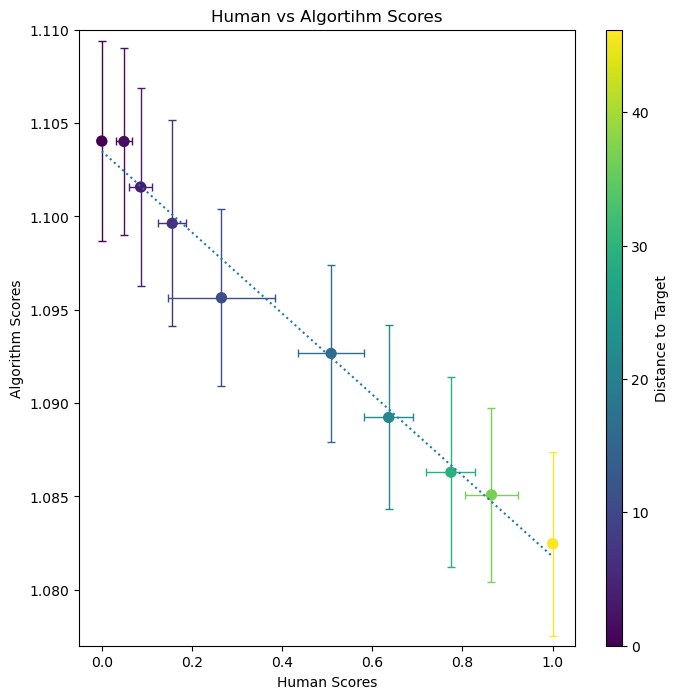

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

x = human_results['distance_eval_mean']
y = algo_results['algorithm_scores_mean']

x_err = human_results['distance_eval_std']  
y_err = algo_results['algorithm_scores_std'] 

colors = algo_results['algorithm_round_ds']

scatter = ax.scatter(x, y, c=colors, s=50, cmap='viridis')

# Add error bars
for i in range(len(x)):
    ax.errorbar(x[i], y[i], xerr=x_err[i], yerr=y_err[i], 
                fmt='o', color=scatter.cmap(scatter.norm(colors[i])), 
                elinewidth=1, capsize=3, capthick=1, zorder=0)

# Create a colorbar
norm = mpl.colors.Normalize(vmin=min(colors), vmax=max(colors))
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, aspect=40)
cbar.set_label('Distance to Target')

# Calculate regression statistics

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

x_reg = np.array([0, 1])
y_reg = slope * x_reg + intercept
plt.plot(x_reg, y_reg, linestyle=':', label='Regression Line')


# p_value_formatted = f"{p_value:.1e}"
# statistic_fontsize = 20
# plt.text(0.35, 0.30, f'r = {r_value:.2f}, '
#                     f'p = {p_value_formatted}', 
#         transform=ax.transAxes,
#         verticalalignment='top',
#         fontsize=statistic_fontsize)

ax.set_xlabel('Human Scores')
ax.set_ylabel('Algorithm Scores')
ax.set_title('Human vs Algortihm Scores')



plt.xlim([-0.05, 1.05])
plt.ylim([1.077, 1.11])
# plt.gca().invert_yaxis()


# Save as high-definition
plotconfig.save_fig("human_vs_algo")

In [11]:
directory = '../../../user_experiments/results'

dfs = []
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

df['match'] = (df['target'] != df['chosen']).astype(int)
mask = ((df['showing_time'] == 500))

df_masked = df[mask]

grouped_df = df_masked.groupby(['rounded_d', 'showing_time'])
compiled_result = grouped_df.agg({
    'match': ['mean', 'std', 'sem', 'count']
})
compiled_result.columns = ['_'.join(col).strip() for col in compiled_result.columns.values]
compiled_result = compiled_result.reset_index()
compiled_result

,rounded_d,showing_time,match_mean,match_std,match_sem,match_count
0,0.0,500,0.493243,0.501652,0.041236,148
1,1.6,500,0.503226,0.501610,0.040290,155
2,3.6,500,0.376623,0.486120,0.039173,154
3,6.8,500,0.289017,0.454622,0.034564,173
4,10.9,500,0.129496,0.336963,0.028581,139
5,16.3,500,0.036649,0.188393,0.013632,191
6,21.7,500,0.031646,0.175611,0.013971,158
7,29.4,500,0.006452,0.080322,0.006452,155
8,36.7,500,0.000000,0.000000,0.000000,165
9,46.2,500,0.006579,0.081111,0.006579,152


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


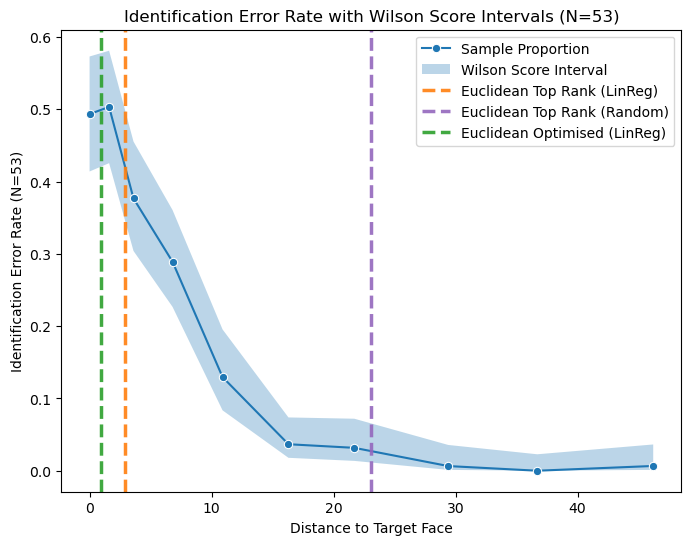

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

# Wilson Score Interval function
def wilson_score_interval(successes, trials, confidence_level=0.95):
    if trials == 0:
        return (0.0, 0.0)  # No trials, no interval
    z = norm.ppf((1 + confidence_level) / 2)
    phat = successes / trials
    denominator = 1 + (z**2 / trials)
    centre_adjusted_probability = phat + (z**2 / (2 * trials))
    adjusted_standard_deviation = np.sqrt((phat * (1 - phat) + (z**2 / (4 * trials))) / trials)
    lower_bound = (centre_adjusted_probability - z * adjusted_standard_deviation) / denominator
    upper_bound = (centre_adjusted_probability + z * adjusted_standard_deviation) / denominator
    return (lower_bound, upper_bound)

# Grouping by 'rounded_d' and calculating success and trial counts
results = df_masked.groupby('rounded_d').agg(successes=('match', 'sum'), trials=('match', 'count')).reset_index()

# Applying Wilson Score Interval function to each group
results[['lower_bound', 'upper_bound']] = results.apply(
    lambda row: pd.Series(wilson_score_interval(row['successes'], row['trials'])), axis=1
)

# Calculate the sample proportion
results['sample_proportion'] = results['successes'] / results['trials']

# Plotting with Seaborn
plt.figure(figsize=(8, 6))
ax = sns.lineplot(data=results, x='rounded_d', y='sample_proportion', label='Sample Proportion', marker='o')
plt.fill_between(results['rounded_d'], results['lower_bound'], results['upper_bound'], alpha=0.3, label='Wilson Score Interval')
plt.xlabel('Distance to Target Face')
plt.ylabel('Identification Error Rate (N=53)')
plt.title('Identification Error Rate with Wilson Score Intervals (N=53)')

ax.axvline(x=2.9, color=sns.color_palette()[1], alpha=0.9, linewidth=2.5, linestyle='--', label='Euclidean Top Rank (LinReg)')
ax.axvline(x=plotconfig.IR_RANDOM_EUCLIDEAN, color=sns.color_palette()[4], alpha=0.9, linewidth=2.5, linestyle='--', label='Euclidean Top Rank (Random)')
ax.axvline(x=0.9, color=sns.color_palette()[2], alpha=0.9, linewidth=2.5, linestyle='--', label='Euclidean Optimised (LinReg)')

plt.legend()

# Save as high-definition
plotconfig.save_fig("match_proba")